# Deep learning downscaling. Version 1

### Project notes

<h3>Background</h3>
This project proposes a methodology to estimate stress in the subsurface by a hybrid method combining finite element modelling and neural networks. This methodology exploits the idea of obtaining a “multi-frequency solution” in the numerical modelling of systems whose behaviour involves a wide span of length scales. One “low-frequency” solution is obtained via inexpensive finite element modelling at a coarse scale. The second solution provides the fine-grained details introduced by the heterogeneity of the free parameters at the fine scale. This “high-frequency” solution is estimated via neural networks pre-trained with partial solutions obtained in high-resolution finite-element models. When the coarse finite element solutions are combined with the neural network estimates, the results are within  a 2% of error of the results that would be computed with high-resolution finite element models. The  paper discusses the benefits and drawbacks of the method and illustrates its applicability via a worked example.

<h3>Workflow</h3>

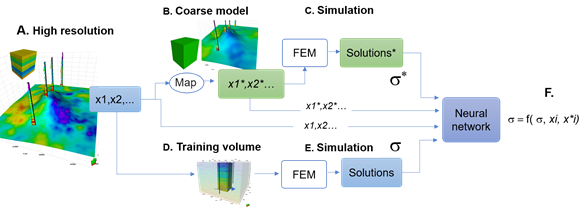

The method starts with a high-resolution model of the subsurface (see Figure 1A), including relevant features of the problem x1,x2...xn. Constructing the model is not a problem in general. The challenge is what to do with that model if solving the elasticity equations becomes prohibitively expensive. This is when a second model comes into play (see Figure 1B). 
The second model is constructed from the high-resolution one but it should be coarse so the elasticity solutions can be obtained inexpensively. Yet, it must be fine enough to capture the overall trends. It may become apparent that if the coarse model is excessively coarse, say for example that is so coarse that has only one cell, it would not capture any relevant information. As shown in Figure 1B, the mechanical properties, pressure, boundary conditions and other relevant features xn are upscaled from the high resolution into a new set of features x*1,x*2…x*n at the coarse scale. The method proposed here is not attached to any particular upscaling method. A basic upscaling method was implemented in this research. 


### Load python libs and project libs

In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from constants import  * 

from py_imports import * 

from plt_imports import * 

from keras_imports import * 
print('Keras version: ' , keras.__version__)

from scikit_imports import *
print('The scikit-learn version is {}.'.format(sklearn.__version__))

import tensorflow as tf
print('Tensor flow version ' , tf.version.VERSION)

a4_dims = (16.7, 5.5)

my_devices = tf.config.experimental.list_physical_devices()#device_type='CPU')
print('done', my_devices)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Keras version:  2.3.1
The scikit-learn version is 0.22.1.
Tensor flow version  2.1.0
done [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Configure globals

In [10]:
preffix = "TrainingVers1_" #version 1 with CNN of 27 neighbours for stress and stiffness
setSeeds(seedNumber)
tf.random.set_seed(seedNumber)
print (seedNumber,preffix)
data_folder = os.path.abspath('../ALLDATA/');

train_area = 8 

42 TrainingVers1_


### Prepare the dataset

###### Filter areas,remove un-needed variables organize rows so the training column is always first

 ###### load data

In [11]:
single_cell_file_name = os.path.join( data_folder,'SINGLECELLDATA.csv') 
df_single_cell = pd.read_feather(single_cell_file_name)
df_single_cell = df_single_cell[ df_single_cell.TRAINAREA >=0 ].copy()

stiffness_file_name = os.path.join( data_folder,'STIFFNESS.csv') 
df_stiffness = pd.read_feather(stiffness_file_name)
df_stiffness = df_stiffness[ df_stiffness.TRAINAREA >=0 ].copy()

strxxfile_name = os.path.join( data_folder,'STRESSXX.csv') 
df_strxx = pd.read_feather(strxxfile_name)
df_strxx = df_strxx[ df_strxx.TRAINAREA >=0 ].copy()

stryyfile_name = os.path.join( data_folder,'STRESSYY.csv')
df_stryy = pd.read_feather(stryyfile_name)
df_stryy = df_stryy[ df_stryy.TRAINAREA >=0 ].copy()



###### some utilities

In [12]:
def pre_process( df, area, kmin, kmax, areas_to_keep,random_state ):
    
    area8 =  shuffle(df[ df.TRAINAREA == area ],random_state = random_state)
    aux   =  shuffle(df[ df.TRAINAREA != area ],random_state = random_state)
    df3 =  pd.concat( [area8, aux], axis = 0 )
 
    k_filter =  (df3['K_FINE'] >= kmin) & (df3['K_FINE'] <= kmax)
    df3 = df3[ k_filter  ].copy()#[ cols_to_keep ]   
    
    main_dataset =  df3[df3.TRAINAREA.isin(areas_to_keep)].reset_index().drop(['index'], axis=1).copy() 
    return main_dataset 
    
def scale_features( f ):
    scaler =  MinMaxScaler((0.015,0.985)); #  
    x  = scaler.fit_transform( f  ) 
    #print('\nScaled feature/output set, with columns: ', f.columns)
    return x, scaler

def get_defaultSettings():
    settings= { 
        'first_layer_units' :  2, 
        'middle_layer_units': 2, 
        'middle_layers': 1, 
        'outputs': 1, 
        'activation' : 'tanh',  #['relu', 'tanh','linear','relu','linear']
        'loss' : 'mean_squared_error',
        'optimizer' : 'sgd',#'rmsprop' 
        'metrics'   : ['mse'],
        'initializer':   'normal', #'random_uniform',
        'regularizerType': None, #'l1',
        'regularizerIntensity':1e-6, 
        'epochs'   : 100,
        'batch' : 32,
        'feature_count': None,
        'useBatchNormalization': False, 
        'rate' : 1.0e-4,
        'momentum': 0.9, #for sgd is the momentum for rmsprop it is the rho coefficient 
        'decay': 0.0  
        }
    return settings;

def update_cummulated_history( newHistory, oldHistory):
    if len(oldHistory.keys()) == 0:
            oldHistory = copy.deepcopy(newHistory)  
    else:
            for key in newHistory.keys():
                oldHistory[key].extend( newHistory[key] )
    return oldHistory;

def pd_to_petrel_points( df, file_name, columns = []):
    print('pd_to_petrel_points');
    tmp =df[ columns ]
    print('Exporting rows ', len(tmp))
    tmp.to_csv(file_name, sep=' ', index = False)
    print('done exporting.')
 


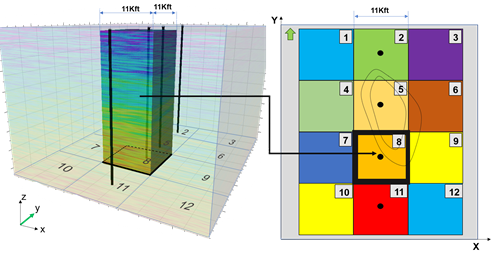

In [13]:
params = {
    'area' : train_area, 
    'kmin' : 64, 
    'kmax' : 600, 
    'areas_to_keep': np.linspace(1,15,15, dtype = int), #all areas from 1 to 15 
    'random_state' : seedNumber   
    }

df_single_cell = pre_process( df_single_cell,**params ); 
df_stiffness   = pre_process( df_stiffness, **params )
df_strxx       = pre_process( df_strxx, **params)
df_stryy       = pre_process( df_stryy, **params)
df_single_cell.to_feather("main_dataset")

drop_from_training =['TRAINAREA','I_FINE','J_FINE','K_FINE']
df_stiffness.drop( drop_from_training,inplace = True, axis = 1)
df_strxx.drop( drop_from_training ,inplace = True, axis = 1)
df_stryy.drop( drop_from_training ,inplace = True, axis = 1)

df_secondary = df_single_cell[ ['TRAINAREA','I_FINE','J_FINE','K_FINE','X','Y','Z','FINE_EFFXX','FINE_EFFYY'] ]
df_output = df_single_cell[['FINE_EFFXX','FINE_EFFYY']].copy()

df_single_cell.drop(['INDEX','X','Y','Z','TRAINAREA','I_FINE','J_FINE','K_FINE','FINE_EFFXX','FINE_EFFYY','FINE_EFFZZ'],inplace=True,axis=1)
df_secondary.to_feather(preffix + "secondary_dataset")




In [14]:
NSAMPLES = len(df_secondary[df_secondary.TRAINAREA == train_area ])
NTRAIN = NSAMPLES #- 2000
NTEST = 2000
NOUTPUTS = df_output.shape[1]
NSAMPLES, NTRAIN, NTEST,NOUTPUTS

(421008, 421008, 2000, 2)

In [15]:
df_single_cell

,FINE_PPR,VC_PPR,VC_EFFXX,VC_EFFYY,VC_EFFZZ,DYM,DPR
0,10655.00,10628.10,7520.30,5942.39,12631.60,-0.57330,-0.006731
1,7613.34,7620.10,4875.77,4023.50,8961.03,-0.41730,0.008347
2,2014.63,1942.84,1426.79,1174.84,2082.26,-0.49319,0.000559
3,9537.79,9608.72,6700.40,5249.88,11553.10,-1.70340,0.015314
4,4927.98,5008.50,3267.62,2734.23,5566.67,-1.42676,0.014721
...,...,...,...,...,...,...,...
5052091,4088.90,4037.82,2697.07,2184.65,4248.22,-1.15848,0.017974
5052092,5855.58,5861.16,3579.54,3076.37,6649.83,1.22278,0.006552
5052093,12475.20,12485.40,8603.22,6919.23,15569.20,1.81180,-0.002152
5052094,11000.00,11009.30,7525.36,6048.35,13138.10,3.35270,-0.023129


In [20]:
df_strxx

AttributeError: 'DataFrame' object has no attribute 'name'

In [17]:
df_stryy

,EFFYY_110,EFFYY_120,EFFYY_130,EFFYY_210,EFFYY_220,EFFYY_230,EFFYY_310,EFFYY_320,EFFYY_330,EFFYY_111,...,EFFYY_331,EFFYY_112,EFFYY_122,EFFYY_132,EFFYY_212,EFFYY_222,EFFYY_232,EFFYY_312,EFFYY_322,EFFYY_332
0,5912.09,5942.39,5942.39,5912.09,5942.39,5942.39,5918.59,5931.91,5931.91,5912.09,...,5931.91,5912.09,5942.39,5942.39,5912.09,5942.39,5942.39,5918.59,5931.91,5931.91
1,4006.07,4025.85,4025.85,3962.18,4023.50,4023.50,3962.18,4023.50,4023.50,4006.07,...,4023.50,4006.07,4025.85,4025.85,3962.18,4023.50,4023.50,3962.18,4023.50,4023.50
2,1177.11,1171.82,1171.82,1179.45,1174.84,1174.84,1179.45,1174.84,1174.84,1177.11,...,1174.84,1259.03,1256.07,1256.07,1247.95,1242.54,1242.54,1247.95,1242.54,1242.54
3,5270.72,5278.83,5278.83,5270.72,5278.83,5278.83,5242.85,5262.83,5262.83,5264.19,...,5247.49,5264.19,5249.88,5249.88,5264.19,5249.88,5249.88,5260.60,5247.49,5247.49
4,2650.22,2677.69,2677.69,2646.76,2698.71,2698.71,2646.76,2698.71,2698.71,2653.55,...,2734.23,2653.55,2701.45,2701.45,2679.14,2734.23,2734.23,2679.14,2734.23,2734.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5052091,2197.95,2174.11,2174.11,2214.79,2184.65,2184.65,2214.79,2184.65,2184.65,2197.95,...,2184.65,2197.95,2174.11,2174.11,2214.79,2184.65,2184.65,2214.79,2184.65,2184.65
5052092,3076.37,3076.37,3101.09,3076.37,3076.37,3101.09,3080.85,3080.85,3110.62,3076.37,...,3110.62,3076.37,3076.37,3101.09,3076.37,3076.37,3101.09,3080.85,3080.85,3110.62
5052093,6874.73,6862.52,6862.52,6901.57,6919.23,6919.23,6901.57,6919.23,6919.23,6874.73,...,6919.23,6874.73,6862.52,6862.52,6901.57,6919.23,6919.23,6901.57,6919.23,6919.23
5052094,6066.15,6048.35,6048.35,6066.15,6048.35,6048.35,6060.97,6047.37,6047.37,6066.15,...,6047.37,6066.15,6048.35,6048.35,6066.15,6048.35,6048.35,6060.97,6047.37,6047.37


###### Scaling

In [18]:
#df_strxx
#df_stryy
#df_stiffness 
#df_single_cell
#df_output
strxx_scaled , strxx_scaler = scale_features( df_strxx )
stryy_scaled , stryy_scaler = scale_features( df_stryy )
ym_scaled , ym_scaler = scale_features( df_stiffness )
single_scaled , single_scaler = scale_features( df_single_cell )
y_scaled , y_scaler = scale_features( df_output )

assert(strxx_scaled.shape == stryy_scaled.shape )
assert(strxx_scaled.shape == stryy_scaled.shape )
assert(ym_scaled.shape == stryy_scaled.shape)
assert(ym_scaled.shape[0] == single_scaled.shape[0])


strxx_scaled.shape, stryy_scaled.shape, ym_scaled.shape,single_scaled.shape, y_scaled.shape

((5052096, 27), (5052096, 27), (5052096, 27), (5052096, 7), (5052096, 2))

array([[0.79238, 0.79275, 0.79275, ..., 0.76973, 0.76698, 0.76698],
       [0.48   , 0.48025, 0.48025, ..., 0.46066, 0.46848, 0.46848],
       [0.07674, 0.0773 , 0.0773 , ..., 0.07518, 0.07606, 0.07606],
       ...,
       [0.91815, 0.9132 , 0.9132 , ..., 0.90564, 0.9079 , 0.9079 ],
       [0.7936 , 0.79334, 0.79334, ..., 0.78217, 0.78019, 0.78019],
       [0.30618, 0.30618, 0.30562, ..., 0.29075, 0.29075, 0.29014]])

###### Resize arrays for convolution

In [ ]:
s0 = strxx_scaled.shape[0]
strxx_scaled=strxx_scaled.reshape( s0, 3,3,3,1 )
stryy_scaled=stryy_scaled.reshape( s0, 3,3,3,1 )

s0 = ym_scaled.shape[0]
ym_scaled=ym_scaled.reshape( s0, 3,3,3,1 )

###### Save all the arrays just in case

In [ ]:
np.save(preffix + 'strxx_scaled', strxx_scaled)
np.save(preffix + 'stryy_scaled', stryy_scaled)
np.save(preffix + 'ym_scaled', ym_scaled)
np.save(preffix + 'single_scaled', single_scaled)
np.save(preffix + 'y_scaled', y_scaled)

dump(strxx_scaler, open(preffix + 'strxx_scaler.pkl', 'wb'))
dump(stryy_scaler, open(preffix + 'stryy_scaler.pkl', 'wb'))
dump(ym_scaler, open(preffix + 'ym_scaler.pkl', 'wb'))
dump(single_scaler, open(preffix + 'single_scaler.pkl', 'wb'))
dump(y_scaler, open(preffix + 'y_scaler.pkl', 'wb'))
 
 

### Model 

In [ ]:
tf.random.set_seed(seedNumber)
settings = get_defaultSettings() 

settings['regularizerIntensity']  = 1.0e-6
settings['epochs'] = 100
settings['rate']=  100e-4   #use 55e-6 for sgd and 25.0e-2 for rmsprop 42.0e-2 for adam 
settings['regularizerType'] = ['l1']
settings['outputs'] = NOUTPUTS
settings['optimizer']='sgd'
settings['activation']='tanh'
settings['useBatchNormalization'] =False 
settings['metrics'] = [ 'mean_absolute_error','mean_absolute_percentage_error']

h= {} 

###### Building 

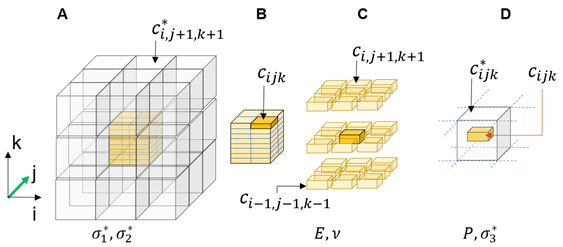

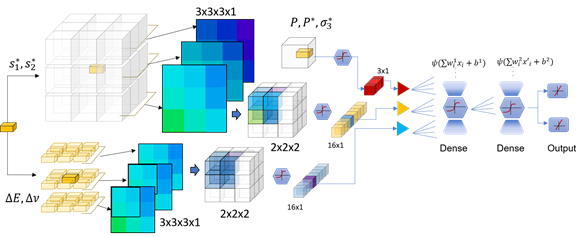

In [ ]:
tf.random.set_seed(seedNumber)
kernel = (2,2,2)
stride = 1
filters = 1 

#input for the three 3D convolutions
strxx_input = Input(shape=(3,3,3,1), name='cube_strxx' )
stryy_input = Input(shape=(3,3,3,1), name='cube_stryy' )
stiffness_input = Input(shape=(3,3,3,1), name='cube_stiffness')

#input for the single-cell branch 
single_cell_Input = Input( shape=(single_scaled.shape[1],), name='single_cell_data' ) 

strxx_conv = Conv3D(filters, kernel_size=kernel,activation='tanh', name = 'strxx')(strxx_input)
strxx_conv = Flatten()(strxx_conv)

stryy_conv = Conv3D(filters, kernel_size=kernel,activation='tanh', name = 'stryy')(stryy_input)
stryy_conv = Flatten()(stryy_conv)

stiffness_conv = Conv3D(filters, kernel_size=kernel,activation='tanh', name = 'stiffness')(stiffness_input)
stiffness_conv = Flatten()(stiffness_conv)

merged = concatenate([strxx_conv, stryy_conv,stiffness_conv, single_cell_Input])


FREENEURONS = 5
NEIGHBOURS = 8 
NFEATURES = single_scaled.shape[1]
layer1 = Dense(FREENEURONS + NFEATURES + 3*NEIGHBOURS , name='L1' ,activation='tanh')(merged)#same_cell_data)
layer2 = Dense(FREENEURONS + NFEATURES + 3*NEIGHBOURS , name='L2' ,activation='tanh')(layer1)
output_layer = Dense(NOUTPUTS, name='Output' ,activation='linear')(layer2)

model = keras.models.Model(inputs=[strxx_input,stryy_input, stiffness_input, single_cell_Input], outputs=output_layer)

sgd = optimizers.SGD(lr = settings['rate'], momentum= settings['momentum'], nesterov=True) #decay=1.0e-6  
model.compile(optimizer=sgd,loss=settings['loss'],metrics=settings['metrics'])          
model.summary()
mx = model;
h = {}

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


##### Training 

In [ ]:
sxx_t = strxx_scaled[0:NTRAIN]
syy_t = stryy_scaled[0:NTRAIN]
ym_t  = ym_scaled[0:NTRAIN]
sc_t = single_scaled[0:NTRAIN]
y_train = y_scaled[0:NTRAIN]

NTEST = NTRAIN + 50000
sxx_v = strxx_scaled[NTRAIN:NTEST]
syy_v = stryy_scaled[NTRAIN:NTEST]
ym_v  = ym_scaled[NTRAIN:NTEST]
sc_v = single_scaled[NTRAIN:NTEST]
y_v = y_scaled[NTRAIN:NTEST]

for scale in [20,20,20,20]:
    settings['epochs'] = scale        
    print('Training with lr ', settings['rate'], ' for epochs ', settings['epochs'])
    
    #k.set_value(mx.optimizer.lr, settings['rate'] )
    
    history = model.fit( [sxx_t,
                          syy_t,
                          ym_t,
                          sc_t], 
                          y_train, 
                          settings['batch'],epochs=settings['epochs'],callbacks=[],
                          verbose=2,
                          validation_data=( [ sxx_v, syy_v, ym_v,sc_v],y_v)                       
                       )
    
    
    h = update_cummulated_history( history.history , h);

    
    epochs = len( h['val_loss'] )   
    name = preffix + str( epochs )+'.h5'
    mx.save( name )
    print('saving model ', name )
        
    pd.DataFrame( h ).to_csv(preffix +'Results.csv')
    print('Saved file ', preffix +'Results.csv')
    

In [ ]:
print('done')

### Storing predictions and exporting for processing

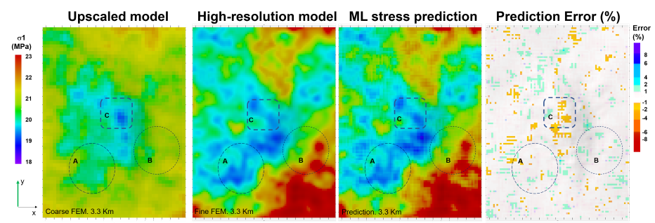

In [ ]:
predictions = mx.predict([strxx_scaled,stryy_scaled,ym_scaled,single_scaled])
predictions_real = y_scaler.inverse_transform( predictions )
print('done')

In [ ]:
df_secondary['PredExx'] = predictions_real[:,0]
df_secondary['PredEyy'] = predictions_real[:,1]

df_secondary['ErrorXX'] = 100.0*( df_secondary['PredExx'] - df_secondary['FINE_EFFXX'])/df_secondary['FINE_EFFXX']
df_secondary['ErrorYY'] = 100.0*( df_secondary['PredEyy'] - df_secondary['FINE_EFFYY'])/df_secondary['FINE_EFFYY']

In [ ]:
#export 
df_secondary.to_feather(preffix + '_Predictions')
print('Exported results: ' + preffix + '_Predictions')

In [ ]:
#check we can read 
results = pd.read_feather(preffix + '_Predictions')

In [ ]:
cols = df_secondary.columns
pd_to_petrel_points( results, preffix + 'results.dat', columns = cols );

In [ ]:
print('done')